In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def extract_keypoints(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    return keypoints, descriptors


In [3]:
def generate_convex_hulls(keypoints):
    hulls = []
    hulls.append(cv2.convexHull(np.array([k.pt for k in keypoints], dtype=np.float32)))
    for i in range(1, len(keypoints)):
        remaining_points = np.array([k.pt for j, k in enumerate(keypoints) if j != i], dtype=np.float32)
        hull = cv2.convexHull(remaining_points)
        if not np.array_equal(hull, hulls[-1]):
            hulls.append(hull)
    return hulls[1:]

In [4]:
def generate_binary_code(hull):
    norms = np.linalg.norm(np.roll(hull, -1, axis=0) - hull, axis=1)
    binary_code = np.zeros_like(norms, dtype=np.uint8)
    for i in range(len(norms)):
        if (norms[i] > norms[(i+1) % len(norms)]).any():
            binary_code[i] = 1
    return binary_code


In [5]:
def generate_hct_code_with_keypoints(image):
    orb = cv2.ORB_create()
    keypoints, descriptors = orb.detectAndCompute(image, None)
    hulls = generate_convex_hulls(keypoints)
    hct_code = np.concatenate([generate_binary_code(h) for h in hulls])
    return hct_code, keypoints


In [6]:
def generate_two_layer_hct(keypoints):
    # Generate the convex hulls for all the keypoints
    hulls = generate_convex_hulls(keypoints)
    
    # Split the hulls into inner and outer layers
    num_hulls = len(hulls)
    inner_hulls = hulls[:num_hulls//2]
    outer_hulls = hulls[num_hulls//2:]
    
    for h in inner_hulls:
        print(generate_binary_code(h).shape)
    inner_hct = np.concatenate([generate_binary_code(h) for h in inner_hulls])
    print(inner_hct.shape)

    
    # Generate the binary codes for each layer
    inner_hct = np.concatenate([generate_binary_code(h) for h in inner_hulls])
    outer_hct = np.concatenate([generate_binary_code(h) for h in outer_hulls]) if outer_hulls else np.array([])
    
    # Return the two-layer HCT
    return np.concatenate([inner_hct, outer_hct])

In [7]:
# Read the omnidirectional image 
omni_image = cv2.imread("C:/Users/govin/Documents/CV/omni_cam/t1152873094.944045_x2.480106_y-0.302402_a-0.008646.jpeg")


# Define the ROI parameters
original_size =480
original_size2=640
outer_mask_radius = 220
inner_mask_radius = 65
center_x = original_size // 2
center_y = original_size2 // 2

# Create a binary mask for the ROI
mask = np.zeros_like(omni_image[:, :, 0])
rows, cols = np.indices(mask.shape)
distance = np.sqrt((rows - center_x)**2 + (cols - center_y)**2)
mask[(distance <= outer_mask_radius) & (distance >= inner_mask_radius)] = 1

# Apply the mask to extract the ROI
roi_image = cv2.bitwise_and(omni_image, omni_image, mask=mask)

# Generate the HCT code for the masked image
hct_code, keypoints = generate_hct_code_with_keypoints(roi_image)


In [8]:
# Display the results
cv2.imshow("Original Image", omni_image)
cv2.imshow("ROI Image", roi_image)
print("HCT Code: ", hct_code)
cv2.waitKey(0)
cv2.destroyAllWindows()

HCT Code:  [[0 0]
 [1 1]
 [0 0]
 ...
 [1 1]
 [0 0]
 [1 1]]


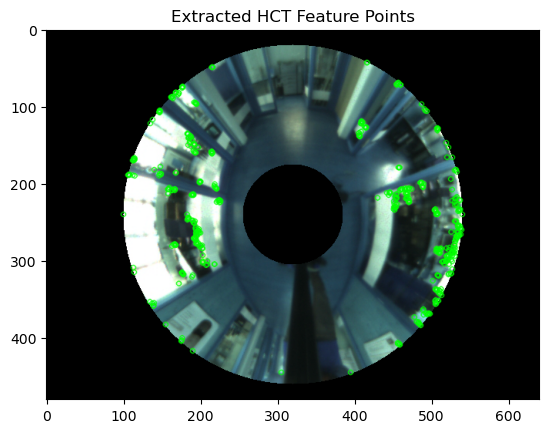

In [9]:
# Plot the HCT feature points
img_with_keypoints = cv2.drawKeypoints(roi_image, keypoints, None, color=(0, 255, 0), flags=cv2.DrawMatchesFlags_DEFAULT)
plt.imshow(img_with_keypoints)
plt.title('Extracted HCT Feature Points')
plt.show()


In [5]:
def extract_convex_hulls(img, keypoints, num_layers):
    # Create a mask of zeros with the same shape as the image
    mask = np.zeros_like(img)

    # Draw keypoints on the mask
    cv2.drawKeypoints(img, keypoints, mask, color=(255,255,255))

    # Convert the mask to binary
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    # Apply morphological opening to remove noise
    kernel = np.ones((5,5),np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    # Extract convex hulls
    hulls = []
    for layer in range(num_layers):
        # Apply dilation to expand the mask
        kernel = np.ones((2*layer+1, 2*layer+1), np.uint8)
        dilation = cv2.dilate(mask, kernel)

        # Find contours in the mask
        contours, hierarchy = cv2.findContours(dilation, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        # Compute convex hull for each contour
        layer_hulls = []
        for contour in contours:
            hull = cv2.convexHull(contour)
            layer_hulls.append(hull)

        hulls.append(layer_hulls)

    return hulls


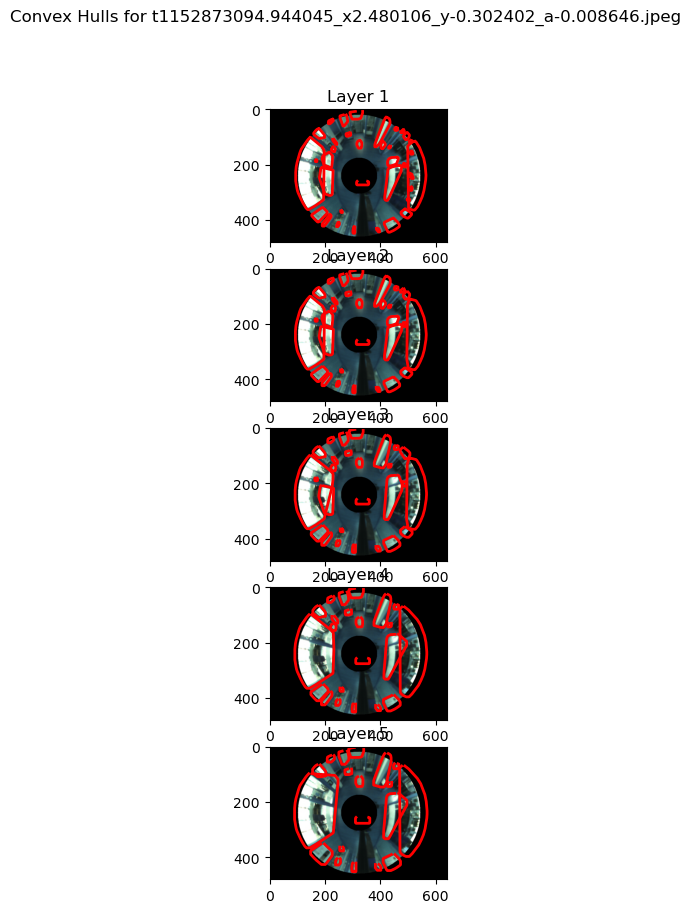

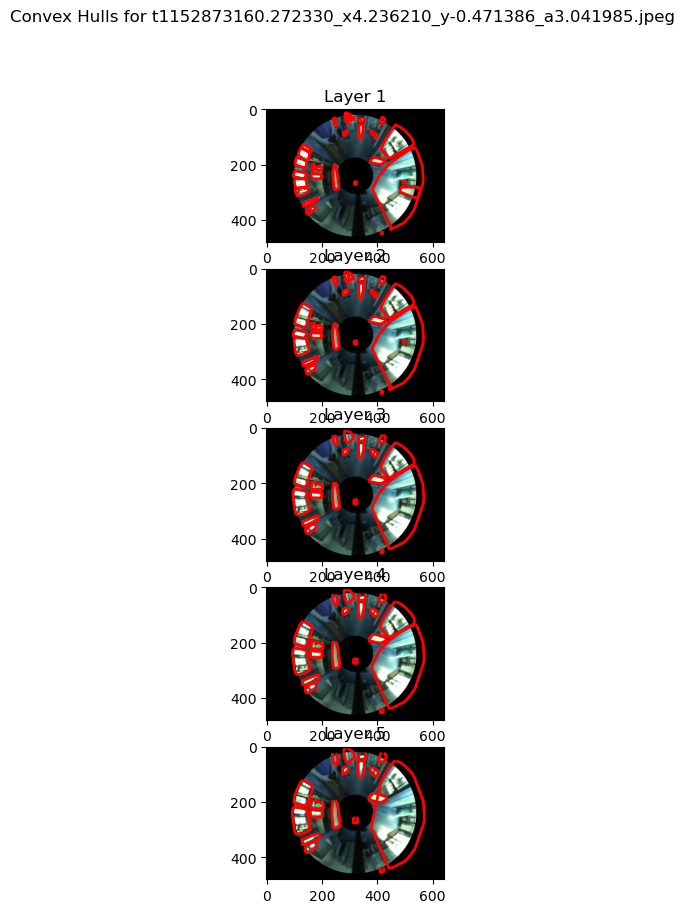

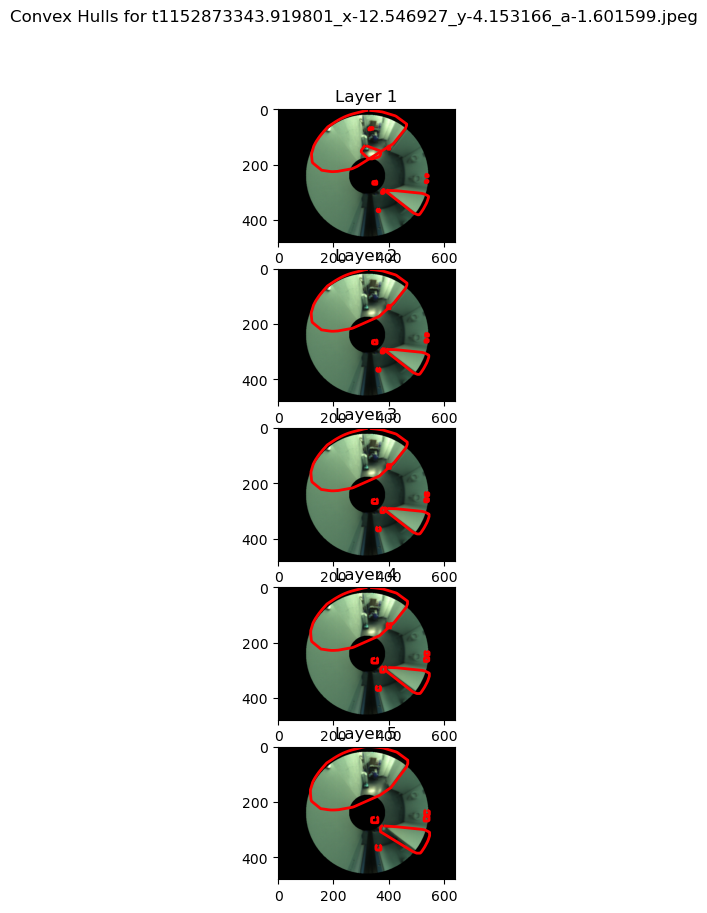

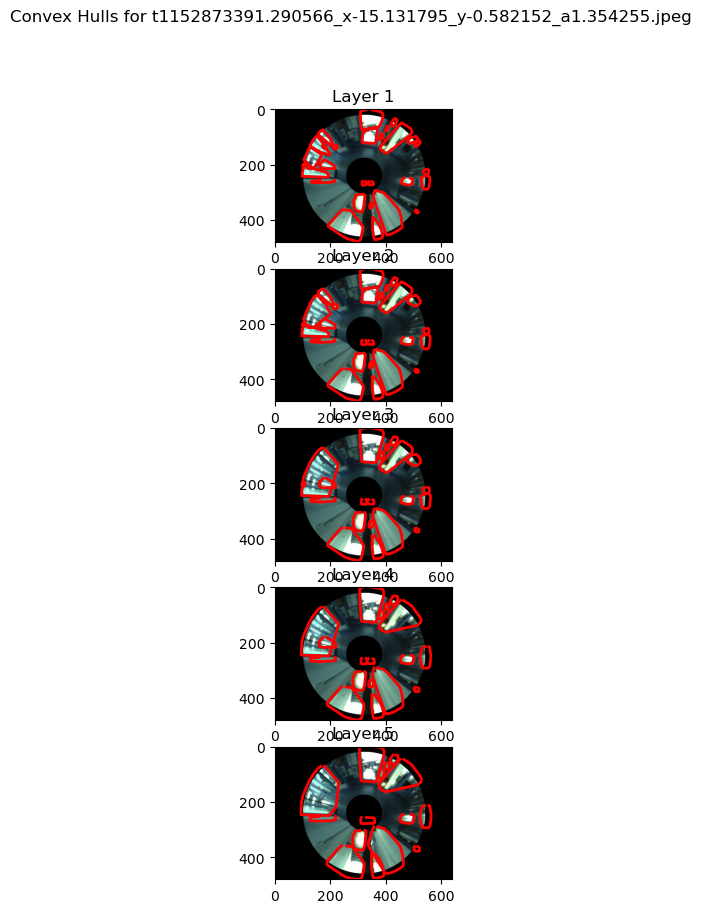

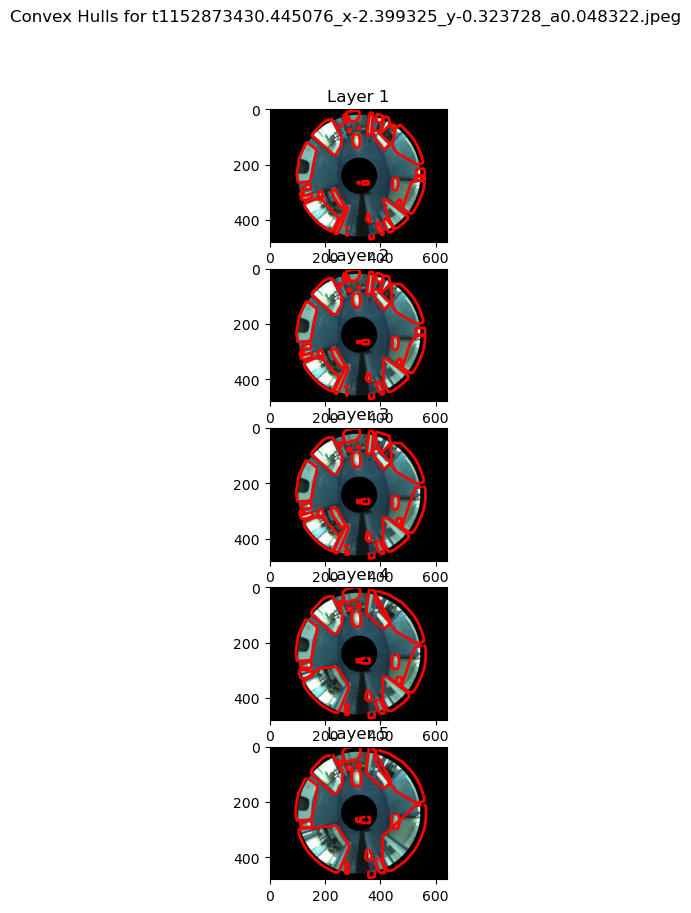

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Define the path to the omnidirectional image dataset
dataset_path = "C:/Users/govin/Documents/CV/omni_cam"

# Initiate ORB detector
orb = cv2.ORB_create()

# Define the number of layers to extract convex hulls
num_layers = 5

# Loop through the image files in the dataset
for filename in os.listdir(dataset_path):
    # Load the omnidirectional image
    img = cv2.imread(os.path.join(dataset_path, filename))
    
    # Define the ROI parameters
    original_size =480
    original_size2=640
    outer_mask_radius = 220
    inner_mask_radius = 65
    center_x = original_size // 2
    center_y = original_size2 // 2

    # Create a binary mask for the ROI
    mask = np.zeros_like(img[:, :, 0])
    rows, cols = np.indices(mask.shape)
    distance = np.sqrt((rows - center_x)**2 + (cols - center_y)**2)
    mask[(distance <= outer_mask_radius) & (distance >= inner_mask_radius)] = 1

    # Apply the mask to extract the ROI
    roi_image = cv2.bitwise_and(img, img, mask=mask)
    
    # Convert to grayscale
    gray = cv2.cvtColor(roi_image, cv2.COLOR_BGR2GRAY)
    
    # Find keypoints and descriptors
    keypoints, descriptors = orb.detectAndCompute(gray, None)
    
    # Extract convex hulls
    hulls = extract_convex_hulls(img, keypoints, num_layers)
    
    # Visualize the convex hulls
    fig, axs = plt.subplots(num_layers, figsize=(10,10))
    fig.suptitle('Convex Hulls for {}'.format(filename))
    for layer in range(num_layers):
        axs[layer].imshow(roi_image)
        axs[layer].set_title('Layer {}'.format(layer+1))
        for hull in hulls[layer]:
            hull = np.int32(hull.reshape(-1,2))
            axs[layer].plot(hull[:,0], hull[:,1], 'r', linewidth=2)
    
    plt.show()
    
 

In [7]:
import cv2
import numpy as np
from scipy.spatial import ConvexHull
import os


In [8]:
def detect_orb_features(images, max_features=5000):
    orb = cv2.ORB_create(max_features)
    results = []
    for img_path in images:
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        keypoints, descriptors = orb.detectAndCompute(img, None)
        results.append((img_path, keypoints))

    return results


In [9]:
def compute_color_histogram(img):
    # Convert image to float32 and normalize intensities
    img = np.float32(img) / 255.0
    # Split color channels
    b, g, r = cv2.split(img)
    # Compute gray channel as weighted sum of R, G, B channels
    gray = 0.299 * r + 0.587 * g + 0.114 * b
    # Compute channel histograms
    hist_r, _ = np.histogram(r, bins=256, range=(0, 1))
    hist_g, _ = np.histogram(g, bins=256, range=(0, 1))
    hist_b, _ = np.histogram(b, bins=256, range=(0, 1))
    hist_gray, _ = np.histogram(gray, bins=256, range=(0, 1))
    # Normalize histograms
    hist_r = hist_r / (img.shape[0] * img.shape[1])
    hist_g = hist_g / (img.shape[0] * img.shape[1])
    hist_b = hist_b / (img.shape[0] * img.shape[1])
    hist_gray = hist_gray / (img.shape[0] * img.shape[1])
    # Concatenate histograms into a single feature vector
    return np.concatenate((hist_r, hist_g, hist_b, hist_gray))

In [10]:

def generate_convex_hull_encoding(img, keypoints):
    # Compute convex hull from keypoints
    pts = np.float32([kp.pt for kp in keypoints]).reshape(-1, 1, 2)
    hull = cv2.convexHull(pts)
    # Compute centroid of convex hull
    M = cv2.moments(hull)
    cx = M['m10'] / M['m00']
    cy = M['m01'] / M['m00']
    # Compute feature magnitude, feature point structure, and color information
    num_layers = 5
    encoding = np.zeros((num_layers, 9))
    for i in range(num_layers):
        # Compute layer radius
        radius = ((i + 1) / num_layers) * np.max(np.linalg.norm(pts - np.array([cx, cy]), axis=-1))
        # Select feature points within layer
        layer_pts = pts[np.where(np.linalg.norm(pts - np.array([cx, cy]), axis=-1) <= radius)]
        if len(layer_pts) > 0:
            # Compute convex hull of layer points
            layer_hull = cv2.convexHull(layer_pts)
            # Compute area and perimeter of layer hull
            area = cv2.contourArea(layer_hull)
            perimeter = cv2.arcLength(layer_hull, closed=True)
            # Compute feature magnitude and feature point structure
            encoding[i, 0] = len(layer_pts) / len(pts)
            encoding[i, 1] = area / (radius**2)
            encoding[i, 2] = perimeter / (2 * radius)
            # Compute color information
            layer_mask = np.zeros(img.shape[:2], dtype=np.uint8)
            cv2.drawContours(layer_mask, [layer_hull], 0, 255, -1)
            layer_img = cv2.bitwise_and(img, img, mask=layer_mask)
            encoding[i, 3:] = compute_color_histogram(layer_img)
    # Return convex hull encoding
    return encoding.flatten()

In [ ]:
def filter_used_features(keypoints, used_keypoints, threshold):
    """
    Filters out previously used feature points using non-maximum suppression.

    Args:
        keypoints: List of keypoints to filter.
        used_keypoints: List of previously used keypoints.
        threshold: Threshold distance for non-maximum suppression.

    Returns:
        List of filtered keypoints.
    """
    filtered_keypoints = []

    # Create a list of coordinates of previously used keypoints
    used_coords = [kp.pt for kp in used_keypoints]

    for kp in keypoints:
        # Calculate the Euclidean distance between the current keypoint and all previously used keypoints
        distances = [np.linalg.norm(np.array(kp.pt) - np.array(coord)) for coord in used_coords]

        # Filter out the current keypoint if its distance to any previously used keypoint is less than the threshold
        if all(dist > threshold for dist in distances):
            filtered_keypoints.append(kp)

    return filtered_keypoints


In [11]:
# specify directory path containing the images
dir_path = "C:/Users/govin/Documents/CV/omni_cam"

# create an empty list to store the image file paths
image_paths = []

# loop through the files in the directory
for file_name in os.listdir(dir_path):
    # create the full file path
    img_path = os.path.join(dir_path, file_name)

    # append the file path to the list
    image_paths.append(img_path)

# print the number of images read
print("Number of images read:", len(image_paths))

orb_results = detect_orb_features(image_paths)


encodings = []
for img_path, keypoints in orb_results:
    encoding = generate_convex_hull_encoding(img_path, keypoints)
    encodings.append(encoding)


Number of images read: 5


AttributeError: 'str' object has no attribute 'shape'

In [5]:
MAX_HCT_LAYERS = 5

def check_hct_layers(encoded_points):
    hct_layers = len(encoded_points)
    if hct_layers > MAX_HCT_LAYERS:
        return True
    else:
        return False


In [6]:
# create an empty list to store the final encodings
final_encodings = []

for img_path, keypoints in orb_results:
    encoding = generate_convex_hull_encoding(img_path, keypoints)

    # check if the number of layers is greater than 5
    if check_hct_layers(encoding):
        # if it is, append the encoding to the final encodings list
        final_encodings.append(encoding)
    else:
        # if it's not, filter out the feature points and repeat from Step 3
        filtered_keypoints = filter_keypoints(keypoints)
        encoding = generate_convex_hull_encoding(img_path, filtered_keypoints)
        if check_hct_layers(encoding):
            final_encodings.append(encoding)
        else:
            print("Image", img_path, "has too few HCT layers and cannot be encoded.")


NameError: name 'filter_keypoints' is not defined

In [ ]:
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Load the encoded feature vectors for all images into a numpy array
encoded_features = np.load('encoded_features.npy')

# Cluster the encoded feature vectors using k-means with k=1000
kmeans = KMeans(n_clusters=1000)
kmeans.fit(encoded_features)
codebook = kmeans.cluster_centers_

# Print the extracted features
print(codebook)

# Visualize the codebook using a scatter plot
fig, ax = plt.subplots()
ax.scatter(codebook[:, 0], codebook[:, 1], s=5)
ax.set_title('Extended-HCT Codebook')
ax.set_xlabel('Dimension 1')
ax.set_ylabel('Dimension 2')
plt.show()
